In [1]:
import pandas as pd
import pandas_ta as pdt
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import evds as ev
from lazypredict.Supervised import LazyRegressor
import requests
import json
from urllib.parse import urlencode
from sklearn.preprocessing import RobustScaler

In [2]:
with open("C:/Users/okand/OneDrive/Desktop/Works/evds_api.txt") as file:
    api_key = file.read()

In [3]:
data_columns={"bist100":"TP.MK.F.BILESIK",
              "bist_islem_hacmi":"TP.MK.ISL.HC",
             "tufe":"TP.FG.J0",
             "ufe":"TP.TUFE1YI.T1",
             "bendeks":"TP.FE.OKTG03",
             "cendeks":"TP.FE.OKTG04",
             "usdtl":"TP.DK.USD.A.YTL",
             "eurtl":"TP.DK.EUR.A.YTL",
             "brentpetrol":"TP.BRENTPETROL.EUBP",
             "tuketici_kredi_faizi":"TP.KTFTUK",
              "1_aya_kad_mev_faizi":"TP.TRY.MT01",
              "3_aya_kad_mev_faizi":"TP.TRY.MT02",
              "6_aya_kad_mev_faizi":"TP.TRY.MT04",
              "1_yıla_kad_mev_faizi":"TP.TRY.MT05",
             "altın":"TP.MK.KUL.YTL",
             "paraarzı_M1":"TP.PR.ARZ01",
             "paraarzı_M2":"TP.PR.ARZ13",
             "paraarzı_M3":"TP.PR.ARZ22",
             "reeskont_faizi":"TP.REESAVANS.AFO",
             "kamuborcstok":"TP.KB.A09",
             "mbaktif":"TP.AB.A01",
             "ihracat_dolar":"TP.ODANA6.Q02",
             "ithalat_dolar":"TP.ODANA6.Q03",
             "rezervler":"TP.AB.B6"}

In [7]:
def download_data(series_code,start_date='01-01-2003',end_date='28-02-2024',frequency=5,aggregationType='avg'):
    params = {
        'series': series_code,
        'startDate': start_date,
        'endDate': end_date,
        'frequency': frequency,
        'aggregationTypes': aggregationType,
        'type': 'json'
    }
    url = f'https://evds2.tcmb.gov.tr/service/evds/{urlencode(params)}'
    response = requests.get(url=url, headers={'key': api_key})
    formatted_response = json.loads(response.content)
    data = formatted_response['items']
    df = pd.DataFrame(data)
    df = df.drop(columns=['UNIXTIME'])
    df[df.columns[1]]=pd.to_numeric(df[df.columns[1]])
    return df

In [9]:
data = download_data(data_columns["bist100"])
data.columns=["Tarih","bist100"]
#data.rename({data_columns["bist100"]:"bist100"},inplace=True)
data.head()


,Tarih,bist100
0,2003-1,104.70
1,2003-2,112.64
2,2003-3,100.69
3,2003-4,108.78
4,2003-5,108.80


In [11]:
def create_dataset(data, data_columns):
    for name, code in list(data_columns.items())[1:]:
        df = download_data(code)
        df.rename(columns={code: name}, inplace=True)
        data = pd.merge(data, df, on='Tarih', how='left')

    data["Tarih"] = pd.to_datetime(data["Tarih"])
    data.set_index("Tarih", inplace=True)

    col_names=[]
    for i in data_columns.keys():
        col_names.append(i)

    data.columns=col_names
    data.iloc[:,1:] = data.iloc[:,1:].shift(1)
    
    return data

data = create_dataset(data, data_columns)
data.head()

,bist100,bist_islem_hacmi,tufe,ufe,bendeks,cendeks,usdtl,eurtl,brentpetrol,tuketici_kredi_faizi,...,altın,paraarzı_M1,paraarzı_M2,paraarzı_M3,reeskont_faizi,kamuborcstok,mbaktif,ihracat_dolar,ithalat_dolar,rezervler
Tarih,,,,,,,,,,,,,,,,,,,,,
2003-01-01,104.70,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2003-02-01,112.64,343765.39,94.77,94.32,94.46,94.47,1.66,1.76,31.18,44.69,...,19.95,NaN,NaN,NaN,64.00,155376296.00,77318754.19,3774.00,4174.00,39034.20
2003-03-01,100.69,474224.60,96.23,97.28,95.23,95.24,1.62,1.75,32.77,46.12,...,18.80,NaN,NaN,NaN,64.00,159412356.00,77581424.81,3274.00,4007.00,36984.50
2003-04-01,108.78,356212.01,98.12,100.40,96.12,96.01,1.66,1.79,30.61,49.31,...,18.36,NaN,NaN,NaN,64.00,162557876.00,77447588.96,4290.00,5476.00,33823.60
2003-05-01,108.80,619595.18,99.09,102.17,97.68,97.49,1.63,1.76,25.07,54.42,...,17.31,NaN,NaN,NaN,64.00,170088086.00,76226578.76,4035.00,4933.00,34492.30


In [12]:
data.drop(index=["2003-01-01"],axis=0,inplace=True)
data.head()

,bist100,bist_islem_hacmi,tufe,ufe,bendeks,cendeks,usdtl,eurtl,brentpetrol,tuketici_kredi_faizi,...,altın,paraarzı_M1,paraarzı_M2,paraarzı_M3,reeskont_faizi,kamuborcstok,mbaktif,ihracat_dolar,ithalat_dolar,rezervler
Tarih,,,,,,,,,,,,,,,,,,,,,
2003-02-01,112.64,343765.39,94.77,94.32,94.46,94.47,1.66,1.76,31.18,44.69,...,19.95,NaN,NaN,NaN,64.00,155376296.00,77318754.19,3774.00,4174.00,39034.20
2003-03-01,100.69,474224.60,96.23,97.28,95.23,95.24,1.62,1.75,32.77,46.12,...,18.80,NaN,NaN,NaN,64.00,159412356.00,77581424.81,3274.00,4007.00,36984.50
2003-04-01,108.78,356212.01,98.12,100.40,96.12,96.01,1.66,1.79,30.61,49.31,...,18.36,NaN,NaN,NaN,64.00,162557876.00,77447588.96,4290.00,5476.00,33823.60
2003-05-01,108.80,619595.18,99.09,102.17,97.68,97.49,1.63,1.76,25.07,54.42,...,17.31,NaN,NaN,NaN,64.00,170088086.00,76226578.76,4035.00,4933.00,34492.30
2003-06-01,109.48,517957.85,100.04,101.53,98.97,98.80,1.49,1.72,25.86,51.10,...,16.74,NaN,NaN,NaN,64.00,173961054.00,71634529.20,4298.00,5171.00,36391.30


Eksik Gözlem değerlerini tespit edelim:

In [16]:
data.isnull().sum()/len(data)

bist100                0.00
bist_islem_hacmi       0.00
tufe                   0.00
ufe                    0.00
bendeks                0.00
cendeks                0.00
usdtl                  0.00
eurtl                  0.00
brentpetrol            0.00
tuketici_kredi_faizi   0.00
1_aya_kad_mev_faizi    0.00
3_aya_kad_mev_faizi    0.00
6_aya_kad_mev_faizi    0.00
1_yıla_kad_mev_faizi   0.00
altın                  0.00
paraarzı_M1            0.14
paraarzı_M2            0.14
paraarzı_M3            0.14
reeskont_faizi         0.00
kamuborcstok           0.00
mbaktif                0.00
ihracat_dolar          0.00
ithalat_dolar          0.00
rezervler              0.00
dtype: float64

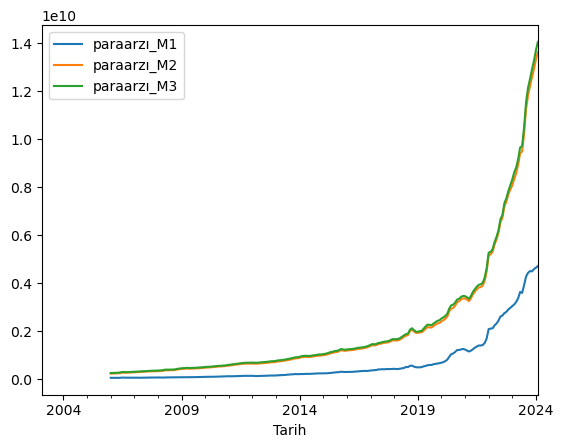

In [18]:
data[["paraarzı_M1","paraarzı_M2","paraarzı_M3"]].plot();

* Para arzı grafiğinde mevsimsellik ve döngüsellik gibi kalıplar yok. fakat imalat kapasite oranı verisinde vardır.
* Genel yapıyı bozmayacak şekilde doldurma işlemi yapacağız.

In [21]:
print(data["bist100"][35:].corr(data["paraarzı_M1"][35:]))
print(data["bist100"][35:].corr(data["paraarzı_M2"][35:]))
print(data["bist100"][35:].corr(data["paraarzı_M3"][35:]))

0.9602909234593596
0.9692254230742939
0.9695649077970456


In [23]:
cols = ["paraarzı_M1", "paraarzı_M2", "paraarzı_M3"]
data[cols] = data[cols].interpolate(method="linear", limit_direction="backward")

print(data["bist100"].corr(data["paraarzı_M1"]))
print(data["bist100"].corr(data["paraarzı_M2"]))
print(data["bist100"].corr(data["paraarzı_M3"]))

0.9619811294635247
0.9708542436081354
0.9711742864331913


In [25]:
data.isnull().sum()

bist100                 0
bist_islem_hacmi        0
tufe                    0
ufe                     0
bendeks                 0
cendeks                 0
usdtl                   0
eurtl                   0
brentpetrol             0
tuketici_kredi_faizi    0
1_aya_kad_mev_faizi     0
3_aya_kad_mev_faizi     0
6_aya_kad_mev_faizi     0
1_yıla_kad_mev_faizi    0
altın                   0
paraarzı_M1             0
paraarzı_M2             0
paraarzı_M3             0
reeskont_faizi          0
kamuborcstok            0
mbaktif                 0
ihracat_dolar           0
ithalat_dolar           0
rezervler               0
dtype: int64

## Öznitelik Mühendisliği

In [29]:
def feature_extraction(data):
    data["dıs_tic_dengesi"]=data["ihracat_dolar"]/data["ithalat_dolar"]
    data["paraarzi_mb_oran"]=data["paraarzı_M3"]/data["mbaktif"]
    data["dolar_eur_ort"]=(data["usdtl"]+data["eurtl"])/2
    data["brent_dolar_tl"]=data["brentpetrol"]*data["usdtl"]

    data["RSI"]=pdt.rsi(data["bist100"], length=14)
    return data

data = feature_extraction(data)

data.head()

,bist100,bist_islem_hacmi,tufe,ufe,bendeks,cendeks,usdtl,eurtl,brentpetrol,tuketici_kredi_faizi,...,kamuborcstok,mbaktif,ihracat_dolar,ithalat_dolar,rezervler,dıs_tic_dengesi,paraarzi_mb_oran,dolar_eur_ort,brent_dolar_tl,RSI
Tarih,,,,,,,,,,,,,,,,,,,,,
2003-02-01,112.64,343765.39,94.77,94.32,94.46,94.47,1.66,1.76,31.18,44.69,...,155376296.00,77318754.19,3774.00,4174.00,39034.20,0.90,3.37,1.71,51.63,NaN
2003-03-01,100.69,474224.60,96.23,97.28,95.23,95.24,1.62,1.75,32.77,46.12,...,159412356.00,77581424.81,3274.00,4007.00,36984.50,0.82,3.36,1.69,53.19,NaN
2003-04-01,108.78,356212.01,98.12,100.40,96.12,96.01,1.66,1.79,30.61,49.31,...,162557876.00,77447588.96,4290.00,5476.00,33823.60,0.78,3.37,1.72,50.68,NaN
2003-05-01,108.80,619595.18,99.09,102.17,97.68,97.49,1.63,1.76,25.07,54.42,...,170088086.00,76226578.76,4035.00,4933.00,34492.30,0.82,3.42,1.70,40.79,NaN
2003-06-01,109.48,517957.85,100.04,101.53,98.97,98.80,1.49,1.72,25.86,51.10,...,173961054.00,71634529.20,4298.00,5171.00,36391.30,0.83,3.64,1.60,38.54,NaN


In [31]:
col_names= data.columns.tolist()
col_names

['bist100',
 'bist_islem_hacmi',
 'tufe',
 'ufe',
 'bendeks',
 'cendeks',
 'usdtl',
 'eurtl',
 'brentpetrol',
 'tuketici_kredi_faizi',
 '1_aya_kad_mev_faizi',
 '3_aya_kad_mev_faizi',
 '6_aya_kad_mev_faizi',
 '1_yıla_kad_mev_faizi',
 'altın',
 'paraarzı_M1',
 'paraarzı_M2',
 'paraarzı_M3',
 'reeskont_faizi',
 'kamuborcstok',
 'mbaktif',
 'ihracat_dolar',
 'ithalat_dolar',
 'rezervler',
 'dıs_tic_dengesi',
 'paraarzi_mb_oran',
 'dolar_eur_ort',
 'brent_dolar_tl',
 'RSI']

In [33]:
def kor(data):
    df = pd.DataFrame(columns=["Yöntem","Gecikme","Korelasyon"])
    for i in range(1,13):
        for j in ["Gecikme","HO"]:
            if j == "Gecikme":
                kor = round(data.corr(data.shift(i)),2)
                df = df._append({"Yöntem":j, "Gecikme":i, "Korelasyon":kor}, ignore_index=True)
            else:
                kor = round(data.corr(data.rolling(window=i).mean()),2)
                df = df._append({"Yöntem":j, "Gecikme":i, "Korelasyon":kor}, ignore_index=True)
    df=df.sort_values(by="Korelasyon",ascending=False)
    return df

for i in col_names[:-1]:
    print(f'bist100 ile {i} korelasyonlar:')
    print(kor(data[i]))
    df=kor(data[i])
    if df.iloc[0,0] == "Gecikme":
        data[f'{i}_gec_{df.iloc[0,1]}']=data[i].shift(df.iloc[0,1])
        if i == "bist100":
            continue
        else:
            data.drop(columns=[i], axis=1, inplace=True)
    else:
        data[f'{i}_HO_{df.iloc[0,1]}']=round(data[i].rolling(window=df.iloc[0,1]).mean(),2)
        if i == "bist100":
            continue
        else:
            data.drop(columns=[i], axis=1, inplace=True)

data.head()

bist100 ile bist100 korelasyonlar:
     Yöntem Gecikme  Korelasyon
0   Gecikme       1        1.00
3        HO       2        1.00
5        HO       3        1.00
1        HO       1        1.00
11       HO       6        0.99
21       HO      11        0.99
19       HO      10        0.99
17       HO       9        0.99
15       HO       8        0.99
13       HO       7        0.99
23       HO      12        0.99
9        HO       5        0.99
7        HO       4        0.99
2   Gecikme       2        0.99
14  Gecikme       8        0.98
4   Gecikme       3        0.98
12  Gecikme       7        0.98
10  Gecikme       6        0.97
8   Gecikme       5        0.97
16  Gecikme       9        0.97
6   Gecikme       4        0.97
18  Gecikme      10        0.97
20  Gecikme      11        0.95
22  Gecikme      12        0.94
bist100 ile bist_islem_hacmi korelasyonlar:
     Yöntem Gecikme  Korelasyon
1        HO       1        1.00
3        HO       2        0.99
5        HO       3      

,bist100,RSI,bist100_gec_1,bist_islem_hacmi_HO_1,tufe_gec_1,ufe_gec_1,bendeks_gec_1,cendeks_gec_1,usdtl_gec_1,eurtl_gec_1,...,reeskont_faizi_HO_2,kamuborcstok_gec_1,mbaktif_gec_1,ihracat_dolar_HO_1,ithalat_dolar_HO_1,rezervler_HO_2,dıs_tic_dengesi_HO_1,paraarzi_mb_oran_HO_2,dolar_eur_ort_gec_1,brent_dolar_tl_HO_2
Tarih,,,,,,,,,,,,,,,,,,,,,
2003-02-01,112.64,NaN,NaN,343765.39,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,3774.00,4174.00,NaN,0.90,NaN,NaN,NaN
2003-03-01,100.69,NaN,112.64,474224.60,94.77,94.32,94.46,94.47,1.66,1.76,...,64.00,155376296.00,77318754.19,3274.00,4007.00,38009.35,0.82,3.36,1.71,52.41
2003-04-01,108.78,NaN,100.69,356212.01,96.23,97.28,95.23,95.24,1.62,1.75,...,64.00,159412356.00,77581424.81,4290.00,5476.00,35404.05,0.78,3.36,1.69,51.94
2003-05-01,108.80,NaN,108.78,619595.18,98.12,100.40,96.12,96.01,1.66,1.79,...,64.00,162557876.00,77447588.96,4035.00,4933.00,34157.95,0.82,3.39,1.72,45.73
2003-06-01,109.48,NaN,108.80,517957.85,99.09,102.17,97.68,97.49,1.63,1.76,...,64.00,170088086.00,76226578.76,4298.00,5171.00,35441.80,0.83,3.53,1.70,39.66


In [35]:
data.drop(columns=["RSI"],axis=1,inplace=True)
data.dropna(inplace=True)

In [37]:
sc = RobustScaler()

In [39]:
y = data["bist100"]
x = data.drop(columns=["bist100"])

x.head()

,bist100_gec_1,bist_islem_hacmi_HO_1,tufe_gec_1,ufe_gec_1,bendeks_gec_1,cendeks_gec_1,usdtl_gec_1,eurtl_gec_1,brentpetrol_HO_1,tuketici_kredi_faizi_HO_2,...,reeskont_faizi_HO_2,kamuborcstok_gec_1,mbaktif_gec_1,ihracat_dolar_HO_1,ithalat_dolar_HO_1,rezervler_HO_2,dıs_tic_dengesi_HO_1,paraarzi_mb_oran_HO_2,dolar_eur_ort_gec_1,brent_dolar_tl_HO_2
Tarih,,,,,,,,,,,,,,,,,,,,,
2003-03-01,112.64,474224.60,94.77,94.32,94.46,94.47,1.66,1.76,32.77,45.40,...,64.00,155376296.00,77318754.19,3274.00,4007.00,38009.35,0.82,3.36,1.71,52.41
2003-04-01,100.69,356212.01,96.23,97.28,95.23,95.24,1.62,1.75,30.61,47.71,...,64.00,159412356.00,77581424.81,4290.00,5476.00,35404.05,0.78,3.36,1.69,51.94
2003-05-01,108.78,619595.18,98.12,100.40,96.12,96.01,1.66,1.79,25.07,51.86,...,64.00,162557876.00,77447588.96,4035.00,4933.00,34157.95,0.82,3.39,1.72,45.73
2003-06-01,108.80,517957.85,99.09,102.17,97.68,97.49,1.63,1.76,25.86,52.76,...,64.00,170088086.00,76226578.76,4298.00,5171.00,35441.80,0.83,3.53,1.70,39.66
2003-07-01,109.48,370250.59,100.04,101.53,98.97,98.80,1.49,1.72,27.65,48.94,...,62.02,173961054.00,71634529.20,4203.00,5459.00,36642.50,0.77,3.70,1.60,38.89


In [41]:
train_size=int(x.shape[0]*0.75)

x_train, y_train = x[:train_size],y[:train_size]
x_test, y_test = x[train_size:], y[train_size:]

print(x_train.shape)
print(x_test.shape)

(189, 28)
(63, 28)


In [43]:
sc_x = RobustScaler()
x_train_scaled = sc_x.fit_transform(x_train)
x_test_scaled = sc_x.transform(x_test)

# Hedef değişken için scaler
sc_y = RobustScaler()
y_train_scaled = sc_y.fit_transform(y_train.values.reshape(-1,1))
y_test_scaled = sc_y.transform(y_test.values.reshape(-1,1))

In [45]:
model = LazyRegressor(verbose=0)
models, tahmin=model.fit(x_train_scaled,x_test_scaled,y_train_scaled,y_test_scaled)
models

  0%|          | 0/42 [00:00<?, ?it/s]

  File "C:\Users\okand\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
               ^^^^^^^^^^^^^^^
  File "C:\Users\okand\anaconda3\Lib\subprocess.py", line 548, in run
    with Popen(*popenargs, **kwargs) as process:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\okand\anaconda3\Lib\subprocess.py", line 1026, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "C:\Users\okand\anaconda3\Lib\subprocess.py", line 1538, in _execute_child
    hp, ht, pid, tid = _winapi.CreateProcess(executable, args,
                       ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000552 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1683
[LightGBM] [Info] Number of data points in the train set: 189, number of used features: 28
[LightGBM] [Info] Start training from score -0.004581
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

,Adjusted R-Squared,R-Squared,RMSE,Time Taken
Model,,,,
PassiveAggressiveRegressor,0.97,0.98,0.76,0.02
OrthogonalMatchingPursuitCV,0.96,0.98,0.85,0.03
OrthogonalMatchingPursuit,0.96,0.98,0.86,0.01
LassoLarsCV,0.95,0.97,0.95,0.11
LassoCV,0.95,0.97,0.96,0.15
LassoLarsIC,0.95,0.97,0.96,0.07
ElasticNetCV,0.95,0.97,0.99,0.18
KernelRidge,0.93,0.96,1.16,0.03
Ridge,0.93,0.96,1.16,0.03


In [73]:
from sklearn.linear_model import PassiveAggressiveRegressor
from sklearn.metrics import r2_score, mean_squared_error

In [59]:
model = PassiveAggressiveRegressor(random_state=0)
model.fit(x_train_scaled, y_train_scaled)
tahmin=model.predict(x_test_scaled)

print(r2_score(y_test_scaled,tahmin))

0.9676663740337781


In [61]:
variables = np.where(model.coef_!=0)[0]
print(x.columns)
print(x.columns[variables])

Index(['bist100_gec_1', 'bist_islem_hacmi_HO_1', 'tufe_gec_1', 'ufe_gec_1',
       'bendeks_gec_1', 'cendeks_gec_1', 'usdtl_gec_1', 'eurtl_gec_1',
       'brentpetrol_HO_1', 'tuketici_kredi_faizi_HO_2',
       '1_aya_kad_mev_faizi_HO_2', '3_aya_kad_mev_faizi_HO_2',
       '6_aya_kad_mev_faizi_HO_2', '1_yıla_kad_mev_faizi_HO_2', 'altın_gec_1',
       'paraarzı_M1_gec_1', 'paraarzı_M2_gec_1', 'paraarzı_M3_gec_1',
       'reeskont_faizi_HO_2', 'kamuborcstok_gec_1', 'mbaktif_gec_1',
       'ihracat_dolar_HO_1', 'ithalat_dolar_HO_1', 'rezervler_HO_2',
       'dıs_tic_dengesi_HO_1', 'paraarzi_mb_oran_HO_2', 'dolar_eur_ort_gec_1',
       'brent_dolar_tl_HO_2'],
      dtype='object')
Index(['bist100_gec_1', 'bist_islem_hacmi_HO_1', 'tufe_gec_1', 'ufe_gec_1',
       'bendeks_gec_1', 'cendeks_gec_1', 'usdtl_gec_1', 'eurtl_gec_1',
       'brentpetrol_HO_1', 'tuketici_kredi_faizi_HO_2',
       '1_aya_kad_mev_faizi_HO_2', '3_aya_kad_mev_faizi_HO_2',
       '6_aya_kad_mev_faizi_HO_2', '1_yıla_kad_me

In [63]:
train_pred = model.predict(x_train_scaled)
train_pred = train_pred.reshape(-1, 1)   # <-- Burası şart
train_pred = sc_y.inverse_transform(train_pred)

test_pred = model.predict(x_test_scaled)
test_pred = test_pred.reshape(-1, 1)     # <-- Aynı şekilde
test_pred = sc_y.inverse_transform(test_pred)

In [65]:
train_pred = pd.DataFrame(train_pred,index = y_train.index)
test_pred = pd.DataFrame(test_pred,index = y_test.index)

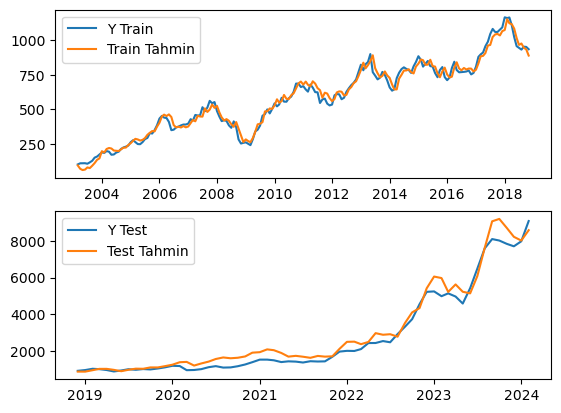

In [67]:
fig,axs=plt.subplots(2,1)

axs[0].plot(y_train,label="Y Train")
axs[0].plot(train_pred,label="Train Tahmin")
axs[0].legend()

axs[1].plot(y_test,label="Y Test")
axs[1].plot(test_pred,label="Test Tahmin")
axs[1].legend()

plt.show()

## Hiper Parametre Optimizasyonu

In [85]:
import optuna
import logging
import sys
import contextlib
import warnings
import os

logging.getLogger("lightgbm").setLevel(logging.ERROR)
warnings.filterwarnings("ignore")

In [87]:
def objective(trial):
    c = trial.suggest_float("C", 0.1, 2.0, log=True)
    mi=trial.suggest_int("max_iter", 500, 5000)
    t = trial.suggest_float("tol",1e-5,1e-1,log=True)
    v = trial.suggest_float("validation_fraction", 0.00001,0.9999,log=True)
    ni = trial.suggest_int("n_iter_no_change", 1, 30)
    e = trial.suggest_float("epsilon", 0.00001,0.9999,log=True)
    r = trial.suggest_int("random_state", 10, 100)

    model = PassiveAggressiveRegressor(random_state=r, 
                                       C=c,
                                       max_iter=mi,
                                       tol=t,
                                       validation_fraction=v,
                                       n_iter_no_change=ni,
                                       epsilon=e)

    model.fit(x_train_scaled, y_train_scaled)
    pred = model.predict(x_test_scaled)
    r2 = r2_score(y_test_scaled,pred)
    return r2


opt=optuna.create_study(direction="maximize")
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    with open(os.devnull, 'w') as fnull:
        with contextlib.redirect_stdout(fnull), contextlib.redirect_stderr(fnull):
            opt.optimize(objective, n_trials=300)

print("En iyi Parametreler: ",opt.best_params)
print("Doğruluk Oranı: ",opt.best_value)


[I 2025-04-29 22:20:24,961] A new study created in memory with name: no-name-a40f6b9d-6a11-43ec-970b-e2e2988709b8
[I 2025-04-29 22:20:24,965] Trial 0 finished with value: 0.9144038855465696 and parameters: {'C': 1.8903209230326565, 'max_iter': 4065, 'tol': 0.07459446978021829, 'validation_fraction': 0.00020462155996845224, 'n_iter_no_change': 30, 'epsilon': 0.19310035805311396, 'random_state': 76}. Best is trial 0 with value: 0.9144038855465696.
[I 2025-04-29 22:20:24,968] Trial 1 finished with value: 0.8647944235354202 and parameters: {'C': 0.23558733080481964, 'max_iter': 4254, 'tol': 0.0002446924415486142, 'validation_fraction': 0.007927783017553081, 'n_iter_no_change': 29, 'epsilon': 0.046772460777027236, 'random_state': 61}. Best is trial 0 with value: 0.9144038855465696.
[I 2025-04-29 22:20:24,972] Trial 2 finished with value: 0.87827233420562 and parameters: {'C': 0.23099914214065653, 'max_iter': 1819, 'tol': 0.002989612413805851, 'validation_fraction': 1.4161943192746454e-05, '

En iyi Parametreler:  {'C': 1.150284002606666, 'max_iter': 2657, 'tol': 0.01841706069264689, 'validation_fraction': 1.7287270562179373e-05, 'n_iter_no_change': 4, 'epsilon': 0.03630318517112391, 'random_state': 29}
Doğruluk Oranı:  0.9844307589609791


In [92]:
model_opt = PassiveAggressiveRegressor(C=1.150284002606666,
                                       max_iter = 2657,
                                       tol = 0.01841706069264689,
                                       validation_fraction = 1.7287270562179373e-05,
                                       n_iter_no_change = 4,
                                       epsilon = 0.03630318517112391,
                                       random_state=29)

model_opt.fit(x_train_scaled, y_train_scaled)
tahmin2=model_opt.predict(x_test_scaled)

print(r2_score(y_test_scaled,tahmin2))


0.9844307589609791


In [94]:
variables = np.where(model_opt.coef_!=0)[0]
print(x.columns)
print(x.columns[variables])

Index(['bist100_gec_1', 'bist_islem_hacmi_HO_1', 'tufe_gec_1', 'ufe_gec_1',
       'bendeks_gec_1', 'cendeks_gec_1', 'usdtl_gec_1', 'eurtl_gec_1',
       'brentpetrol_HO_1', 'tuketici_kredi_faizi_HO_2',
       '1_aya_kad_mev_faizi_HO_2', '3_aya_kad_mev_faizi_HO_2',
       '6_aya_kad_mev_faizi_HO_2', '1_yıla_kad_mev_faizi_HO_2', 'altın_gec_1',
       'paraarzı_M1_gec_1', 'paraarzı_M2_gec_1', 'paraarzı_M3_gec_1',
       'reeskont_faizi_HO_2', 'kamuborcstok_gec_1', 'mbaktif_gec_1',
       'ihracat_dolar_HO_1', 'ithalat_dolar_HO_1', 'rezervler_HO_2',
       'dıs_tic_dengesi_HO_1', 'paraarzi_mb_oran_HO_2', 'dolar_eur_ort_gec_1',
       'brent_dolar_tl_HO_2'],
      dtype='object')
Index(['bist100_gec_1', 'bist_islem_hacmi_HO_1', 'tufe_gec_1', 'ufe_gec_1',
       'bendeks_gec_1', 'cendeks_gec_1', 'usdtl_gec_1', 'eurtl_gec_1',
       'brentpetrol_HO_1', 'tuketici_kredi_faizi_HO_2',
       '1_aya_kad_mev_faizi_HO_2', '3_aya_kad_mev_faizi_HO_2',
       '6_aya_kad_mev_faizi_HO_2', '1_yıla_kad_me

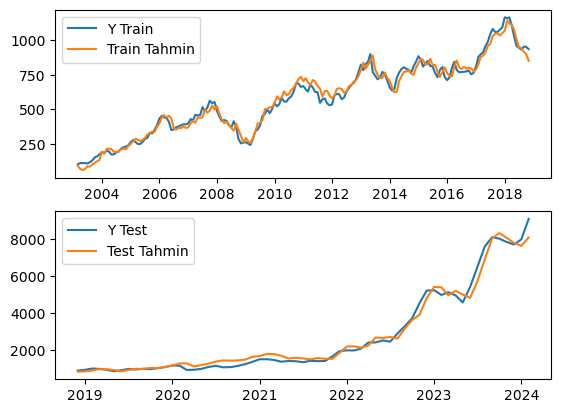

In [96]:
train_pred = model_opt.predict(x_train_scaled)
train_pred = train_pred.reshape(-1, 1)  
train_pred = sc_y.inverse_transform(train_pred)

test_pred = model_opt.predict(x_test_scaled)
test_pred = test_pred.reshape(-1, 1) 
test_pred = sc_y.inverse_transform(test_pred)

train_pred = pd.DataFrame(train_pred,index = y_train.index)
test_pred = pd.DataFrame(test_pred,index = y_test.index)

fig,axs=plt.subplots(2,1)

axs[0].plot(y_train,label="Y Train")
axs[0].plot(train_pred,label="Train Tahmin")
axs[0].legend()

axs[1].plot(y_test,label="Y Test")
axs[1].plot(test_pred,label="Test Tahmin")
axs[1].legend()

plt.show()

In [98]:
import pickle

In [102]:
save_path = "C:/Users/okand/OneDrive/Desktop/Works/bist_model.pkl"

with open(save_path, "wb") as f:
    pickle.dump(model_opt,f)